# Project 1

Jon Montgomery

## Data
I used Robert Shiller's dataset called *US Stock Price, Earnings and Dividends as well as Interest Rates and  Cyclically Adjusted Price Earnings Ratio (CAPE) since 1871* for this analysis.

Robert Shiller is the author or *Irrational Exuberance*, and Sterling Professor of Economics and Finance Emeritus at Yale University.

Link to data:

`https://shillerdata.com/`

Download ie_data.xls

Terms:

- CAPE: Cyclically Adjusted Price Earnings Ratio P/E10. This value is intended to smooth out earnings volatility over time to help assess whether the market is overvalued or undervalued. 
$$
\mathrm{CAPE}=\frac{\mathrm{Real Price}}{\mathrm{Average of Real Earnings over the prior 10 years}}
$$
- Excess CAPE Yield: Derived from the CAPE ratio, adjusted for interest rates. It's designeed to compare the relative attractiveness of equities vs bonds. $r_{f}$ is the real risk-free rate, proxied by 10-year inflation-index treasurey bonds (TIPS).
$$
\mathrm{CAPE}_{excess\_yield}=\frac{1}{\mathrm{CAPE}}-r_{f}
$$
- Monthly Total Bond Returns: The total investment returns for holding a long-term US bond for a month including price appreciation and coupon interest.
- 10 Year Annualized Stock Real Return: The annualized real (inflation-adjusted) return of the stock market over the prior 10 years.
- 10 Year Annualized Bonds Real Return: The annualized real (inflation-adjusted) return of holding long-term US bonds over the prior 10 years.
- Real 10 Year Excess Annualized Returns: The annualized real (inflation-adjusted) return of the stock market over the prior 10 years, in excess of the real risk-free rate (long-term government bond yield).
- Inflation: Relative change in the CPI over a one-year period.
- IASR: Inflation Adjusted Stock Returns over the past N years.

I also pulled in the US national debt for the date range, because it may be useful in this analysis. The debt is measured annually. For this project, I will linearly interpolate the debt between yearly measurements.

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

### Load the data

In [2]:
if not os.path.isfile("./shiller_data.xlsx"):
  shiller_url = "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/02d69a38-97f2-45f8-941d-4e4c5b50dea7/ie_data.xls?ver=1743773003799"
  response = requests.get(shiller_url)
  response.raise_for_status()  # Raise an error for bad status codes
  with open('./shiller_data.xlsx', 'wb') as f:
    f.write(response.content)

# Load into pandas DataFrame
with open("./shiller_data.xlsx", "rb") as f:
    df_raw = pd.read_excel(f, sheet_name="Data", header=7).rename(columns={
      "P": "Price",
      "D": "Dividend",
      "E": "Earnings",
      "Fraction": "Date Fraction",
      "Rate GS10": "Long Interest Rate",
      "Price": "Inflation Adjusted Price",
      "Dividend": "Inflation Adjusted Dividend",
      "Price.1": "Inflation Adjusted Total Return Price",
      "Earnings": "Inflation Adjusted Earnings",
      "Yield": "Excess CAPE Yield",
      "Returns": "Monthly Total Bond Returns",
      "Returns.1": "Inflation Adjusted Total Bond Returns",
      "Real Return": "10 Year Annualized Stock Real Return",
      "Real Return.1": "10 Year Annualized Bonds Real Return",
      "Returns.2": "Real 10 Year Excess Annualized Returns"
    }).drop(columns=[
      "Earnings.1",
      "Unnamed: 13",
      "Unnamed: 15",
      "TR CAPE"
    ]).assign(
      Price=lambda d: d["Price"].apply(lambda x: np.nan if isinstance(x, str) else x),
      CPI=lambda d: d["CPI"].apply(lambda x: np.nan if isinstance(x, str) else x),
    ).merge(
      pd.read_csv("./debt_data.csv").assign(
        Date = lambda d: pd.to_datetime(d["Record Date"])
      ).set_index("Date").resample("MS").asfreq().reset_index().assign(
        Debt = lambda d: d["Debt Outstanding Amount"].interpolate(method='linear'),
        Date = lambda d: d["Date"].dt.year + (d["Date"].dt.month / 100)
      ).drop(columns=[
        "Record Date",
        "Debt Outstanding Amount"
      ]),
      on="Date", how="left"
    )

#### Check for null values

In [3]:
df_raw.isnull().sum()

Date                                        1
Price                                       1
Dividend                                    5
Earnings                                    5
CPI                                         1
Date Fraction                               1
Long Interest Rate                          0
Inflation Adjusted Price                    1
Inflation Adjusted Dividend                 5
Inflation Adjusted Total Return Price       1
Inflation Adjusted Earnings                 5
CAPE                                      121
Excess CAPE Yield                         121
Monthly Total Bond Returns                  2
Inflation Adjusted Total Bond Returns       1
10 Year Annualized Stock Real Return      121
10 Year Annualized Bonds Real Return      121
Real 10 Year Excess Annualized Returns    121
Debt                                        8
dtype: int64

In [4]:
# The null Date row is included by error. All values are null.
df = df_raw[~df_raw.Date.isnull()]
# Dividends and Earnings are null for 2025. We will drop these values and restrict our analysis to 1871-2024
# We only have debt data until September 2024, so we will drop all values after that.
df = df[df["Date"] <= 2024.09]

In [5]:
df.isnull().sum()

Date                                        0
Price                                       0
Dividend                                    0
Earnings                                    0
CPI                                         0
Date Fraction                               0
Long Interest Rate                          0
Inflation Adjusted Price                    0
Inflation Adjusted Dividend                 0
Inflation Adjusted Total Return Price       0
Inflation Adjusted Earnings                 0
CAPE                                      120
Excess CAPE Yield                         120
Monthly Total Bond Returns                  0
Inflation Adjusted Total Bond Returns       0
10 Year Annualized Stock Real Return      113
10 Year Annualized Bonds Real Return      113
Real 10 Year Excess Annualized Returns    113
Debt                                        0
dtype: int64

We can safely remove the row where the Date value is null because it appears to be completely empty and contains no information.

Dividends and earnings data are null for the first quarter of 2025, so we will remove 2025 from consideration in this analysis. We only have debt data up to September of 2024, so we will drop all values after that date.

Dates between 1871-1880 are missing values for CAPE because there is less than 10 years of data. The CAPE calculation requires prior data to establish cyclical earnings trends.

2016-2025 are missing 10-year returns data because there isn't enough data to establish 10-year returns. In this analysis, we retain those rows because they still contain the raw information about S&P Price, Dividends, and other values. They will be excluded from analysis that uses the relevant calculated values.

In [6]:
# Calculate Inflation
df_prior = df[['Date', 'CPI']].copy()
df_prior['Date'] = df_prior['Date'] + 1
df_prior = df_prior.rename(columns={'CPI': 'CPI_prior'})
df = pd.merge_asof(df, df_prior, on='Date', direction='backward')
df['Inflation'] = (df['CPI'] / df['CPI_prior'] - 1) * 100

# Calculate 10-year future stock market returns
df_future10 = df[['Date', 'Inflation Adjusted Price']].copy()
df_future10['Date'] = df_future10['Date'] - 10
df_future10 = df_future10.rename(columns={'Inflation Adjusted Price': 'Future Inflation Adjusted Price 10'})
df = pd.merge_asof(df, df_future10, on='Date', direction='nearest')
df['10 Year IASR'] = (((df['Future Inflation Adjusted Price 10'] / df['Inflation Adjusted Price']) - 1) / 10) * 100

# Calculate 1-year future stock market returns
df_future1 = df[['Date', 'Inflation Adjusted Price']].copy()
df_future1['Date'] = df_future1['Date'] - 1
df_future1 = df_future1.rename(columns={'Inflation Adjusted Price': 'Future Inflation Adjusted Price 1'})
df = pd.merge_asof(df, df_future1, on='Date', direction='forward')
df['1 Year IASR'] = ((df['Future Inflation Adjusted Price 1'] / df['Inflation Adjusted Price']) - 1) * 100

# Calculate the prior year's debt growth
df_prior = df[['Date', 'Debt']].copy()
df_prior['Date'] = df_prior['Date'] + 1
df_prior = df_prior.rename(columns={'Debt': 'Debt_prior'})
df = pd.merge_asof(df, df_prior, on='Date', direction='backward')
df['Debt Growth'] = df['Debt'] - df['Debt_prior']

CPI_base = df[df["Date"] == df["Date"].max()]["CPI"].iloc[0]
# Calculate inflation adjusted debt
df["Inflation Adjusted Debt"] = df["Debt"] * CPI_base / df["CPI"]
df["Inflation Adjusted Debt Growth"] = df["Debt Growth"] * CPI_base / df["CPI"]

### Explore the data

#### How are the variables distributed?
Let's look at the distribution of our economic performance metrics over time, and as a whole. Some measurements are priced in dollars, so Shiller's data includes the actual measured value and an inflation-adjusted value for these measurements.

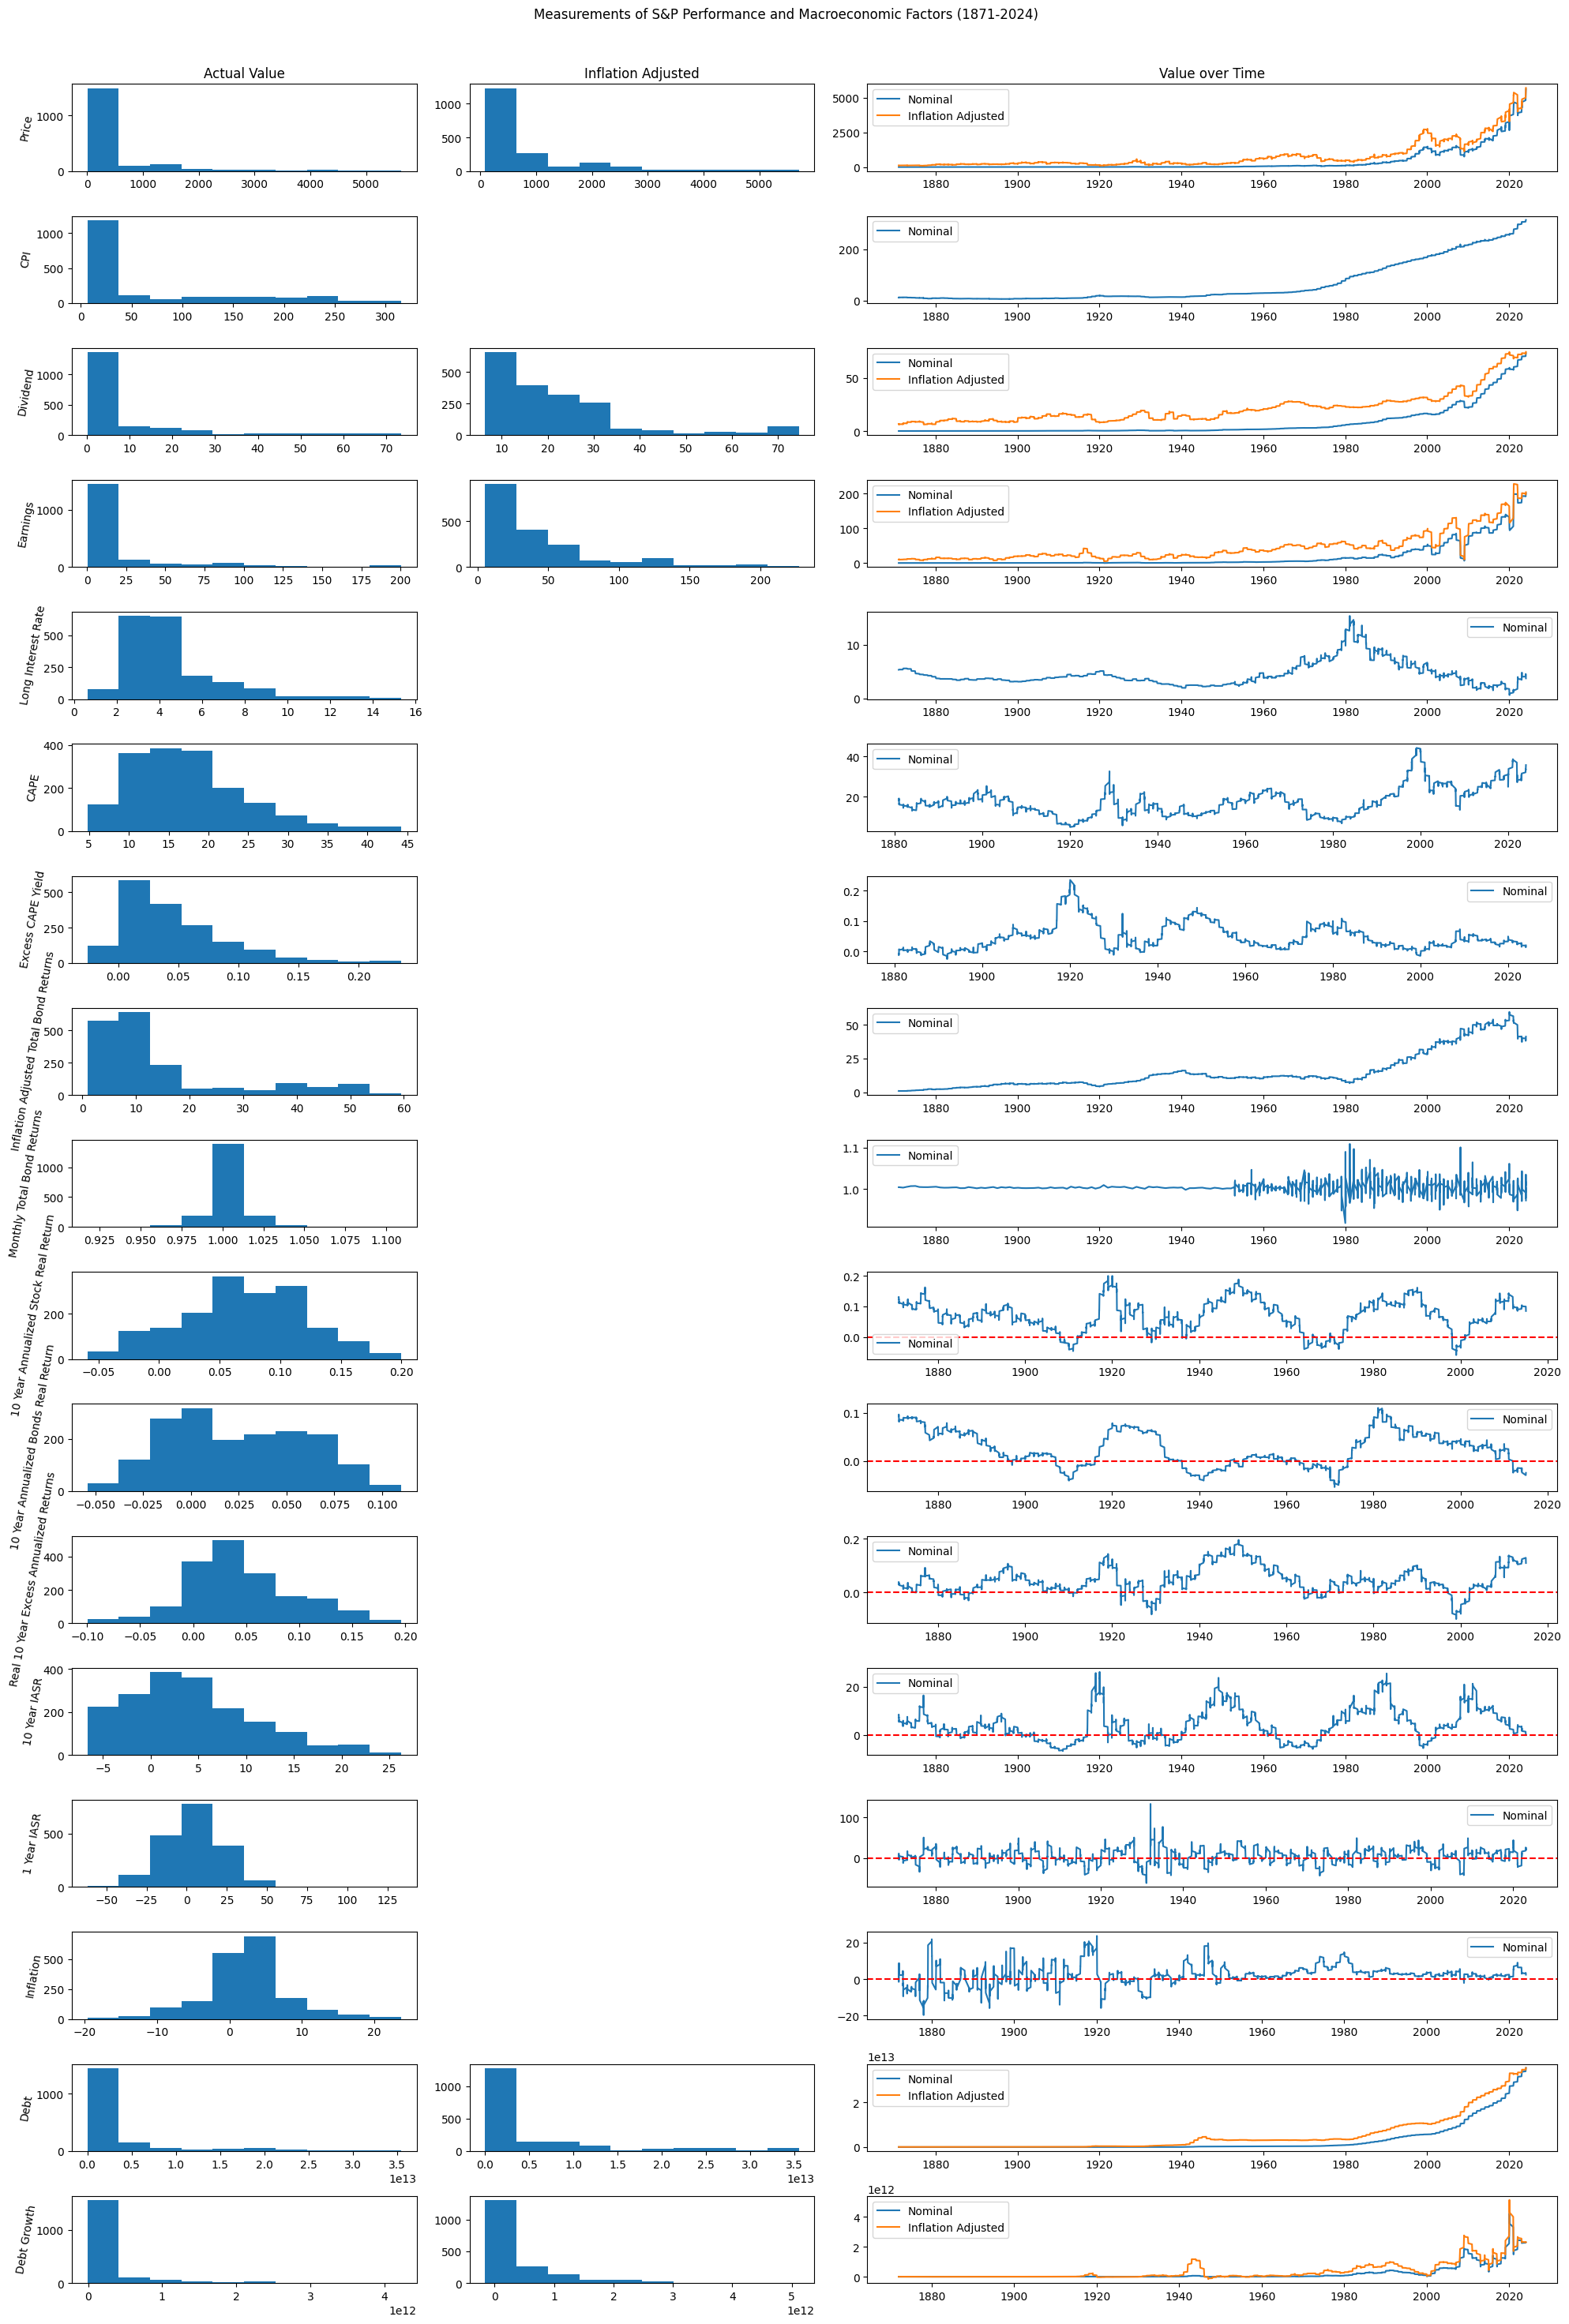

In [7]:
# Column descriptor and whether it has a paired inflation adjusted column
subjects = [
  ("Price", "Inflation Adjusted Price", False),
  ("CPI", None, False),
  ("Dividend", "Inflation Adjusted Dividend", False),
  ("Earnings", "Inflation Adjusted Earnings", False),
  ("Long Interest Rate", None, False),
  ("CAPE", None, False),
  ("Excess CAPE Yield", None, False),
  ("Inflation Adjusted Total Bond Returns", None, False),
  ("Monthly Total Bond Returns", None, False),
  ("10 Year Annualized Stock Real Return", None, True),
  ("10 Year Annualized Bonds Real Return", None, True),
  ("Real 10 Year Excess Annualized Returns", None, True),
  ("10 Year IASR", None, True),
  ("1 Year IASR", None, True),
  ("Inflation", None, True),
  ("Debt", "Inflation Adjusted Debt", False),
  ("Debt Growth", "Inflation Adjusted Debt Growth", False)
]

# Display plots to visualize the distributions
fig, axes = plt.subplots(len(subjects), 3, figsize=(20, 30), gridspec_kw={'width_ratios': [1, 1, 2]})
# Set subplot-column titles
axes[0, 0].set_title("Actual Value")
axes[0, 1].set_title("Inflation Adjusted")
axes[0, 2].set_title("Value over Time")
for ((nax, iaax, tax), (subject, adjusted_subject, include_zero_line)) in zip(axes, subjects):
  nax.set_ylabel(subject, rotation=80)
  nax.hist(df[subject])
  sns.lineplot(data=df, x="Date", y=subject, label="Nominal", ax=tax)
  tax.legend()
  if adjusted_subject:
    iaax.hist(df[adjusted_subject])
    sns.lineplot(data=df, x="Date", y=adjusted_subject, label="Inflation Adjusted", ax=tax)
  else:
    fig.delaxes(iaax)
  if include_zero_line:
    tax.axhline(y=0, color="red", linestyle="--")
  tax.set_ylabel("")
  tax.set_xlabel("")
plt.tight_layout(rect=[0, 0, 1, 0.96])
_ = plt.suptitle("Measurements of S&P Performance and Macroeconomic Factors (1871-2024)")


### Let's analyze the effect of various important events on stock prices

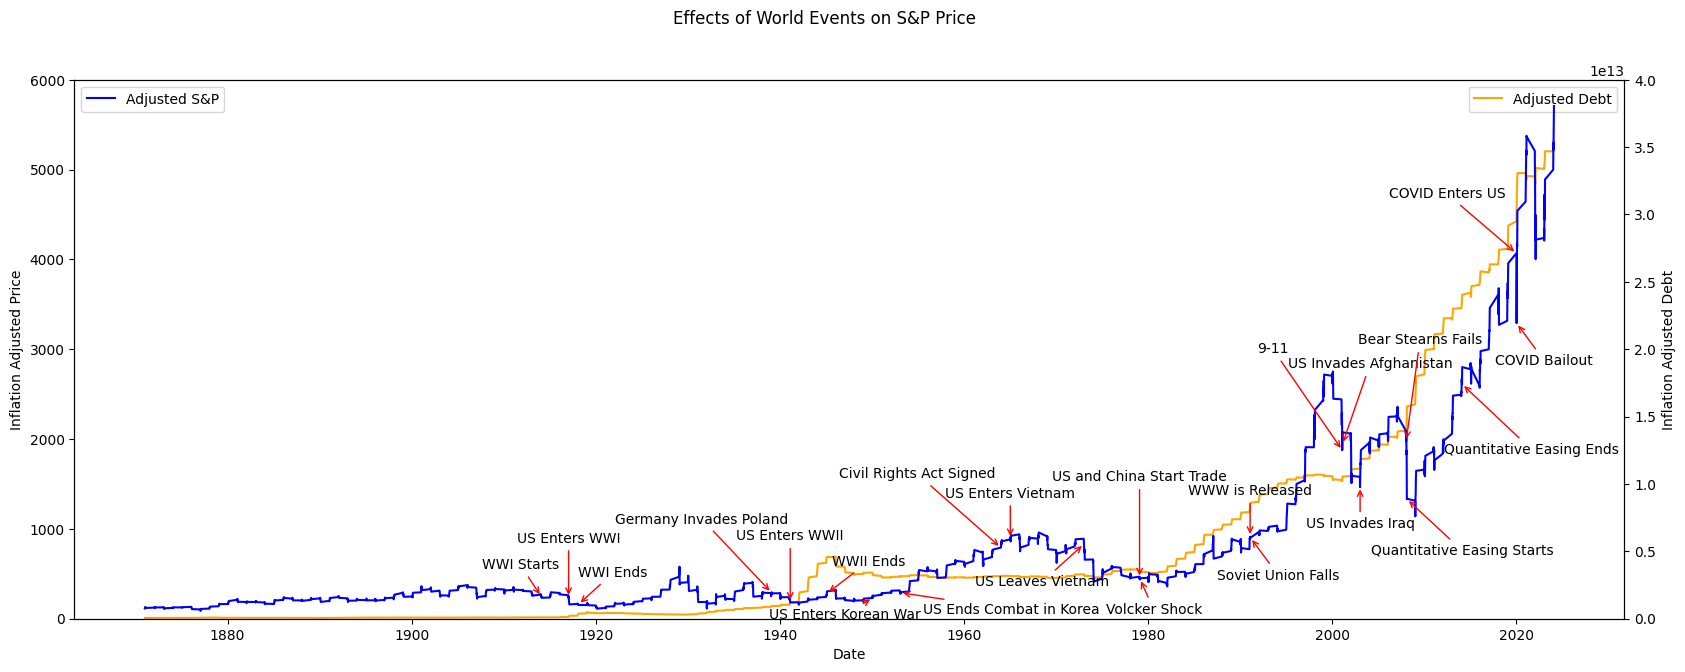

In [22]:
important_events = {
  "WWI Starts": (1914.07, -15, 20),
  "US Enters WWI": (1917.04, 0, 40),
  "WWI Ends": (1918.11, 25, 20),
  "Germany Invades Poland": (1939.09, -50, 50),
  "US Enters WWII": (1941.12, 0, 45),
  "WWII Ends": (1945.09, 30, 20),
  "US Enters Korean War": (1950.07, -20, -15),
  "US Ends Combat in Korea": (1953.07, 80, -15),
  "Civil Rights Act Signed": (1964, -60, 50),
  "US Enters Vietnam": (1965.03, 0, 30),
  "US Leaves Vietnam": (1973.03, -30, -30),
  "US and China Start Trade": (1979.07, 0, 70),
  "Volcker Shock": (1979.10, 10, -25),
  "WWW is Released": (1991.08, 0, 30),
  "Soviet Union Falls": (1991.12, 20, -30),
  "9-11": (2001.09, -50, 70),
  "US Invades Afghanistan": (2001.10, 20, 55),
  "US Invades Iraq": (2003.03, 0, -30),
  "Bear Stearns Fails": (2008.03, 10, 70),
  "Quantitative Easing Starts": (2008.11, 40, -40),
  "Quantitative Easing Ends": (2014.10, 50, -50),
  "COVID Enters US": (2020.01, -50, 40),
  "COVID Bailout": (2020.03, 20, -30)
}

fig, ax1 = plt.subplots(figsize=(20, 7))

sns.lineplot(data=df, x="Date", y="Inflation Adjusted Price", ax=ax1, color="blue", label="Adjusted S&P")
ax2 = ax1.twinx()
sns.lineplot(data=df, x="Date", y="Inflation Adjusted Debt", ax=ax2, color="orange", label="Adjusted Debt")
ax2.set_ylim(0, 4*10**13)
ax1.set_ylim(0, 6000)
ax2.set_zorder(0)
ax1.set_zorder(1)
ax1.patch.set_visible(False)

for event, (date, xoff, yoff) in important_events.items():
  ax1.annotate(
      event,                    # Text label
      xy=(date, df.loc[(df['Date'] - date).abs().idxmin()]["Inflation Adjusted Price"]),
      xytext=(xoff, yoff),
      textcoords='offset points',
      ha='center',
      arrowprops=dict(
          arrowstyle='->',
          color='red',
          linewidth=1
      )
  )
  plt.suptitle("Effects of World Events on S&P Price")

We can see that wars and events have complicated influences on the stock market. The period between 1910 and 1950 represents almost zero real growth, containing both world wars. After the end of WWII, the market goes into a long period of growth, peaking around the time that the US enters vietnam, after which it falls until the deregulation and globalization of the 1980s. Following the 1979 inflation crisis and the Volcker Shock response, the market goes into a period of exponential growth as tech stocks explode until the dot com bubble pops in 2000, followed by 9-11 and the US invasions of Iraq and Afganistan. Growth resumes until 2008, falling below the lows of 2001. Quantitative easing pushes the market upward and the market has increased at an extreme rate with some turbulence around COVID.

### Relationships between variables

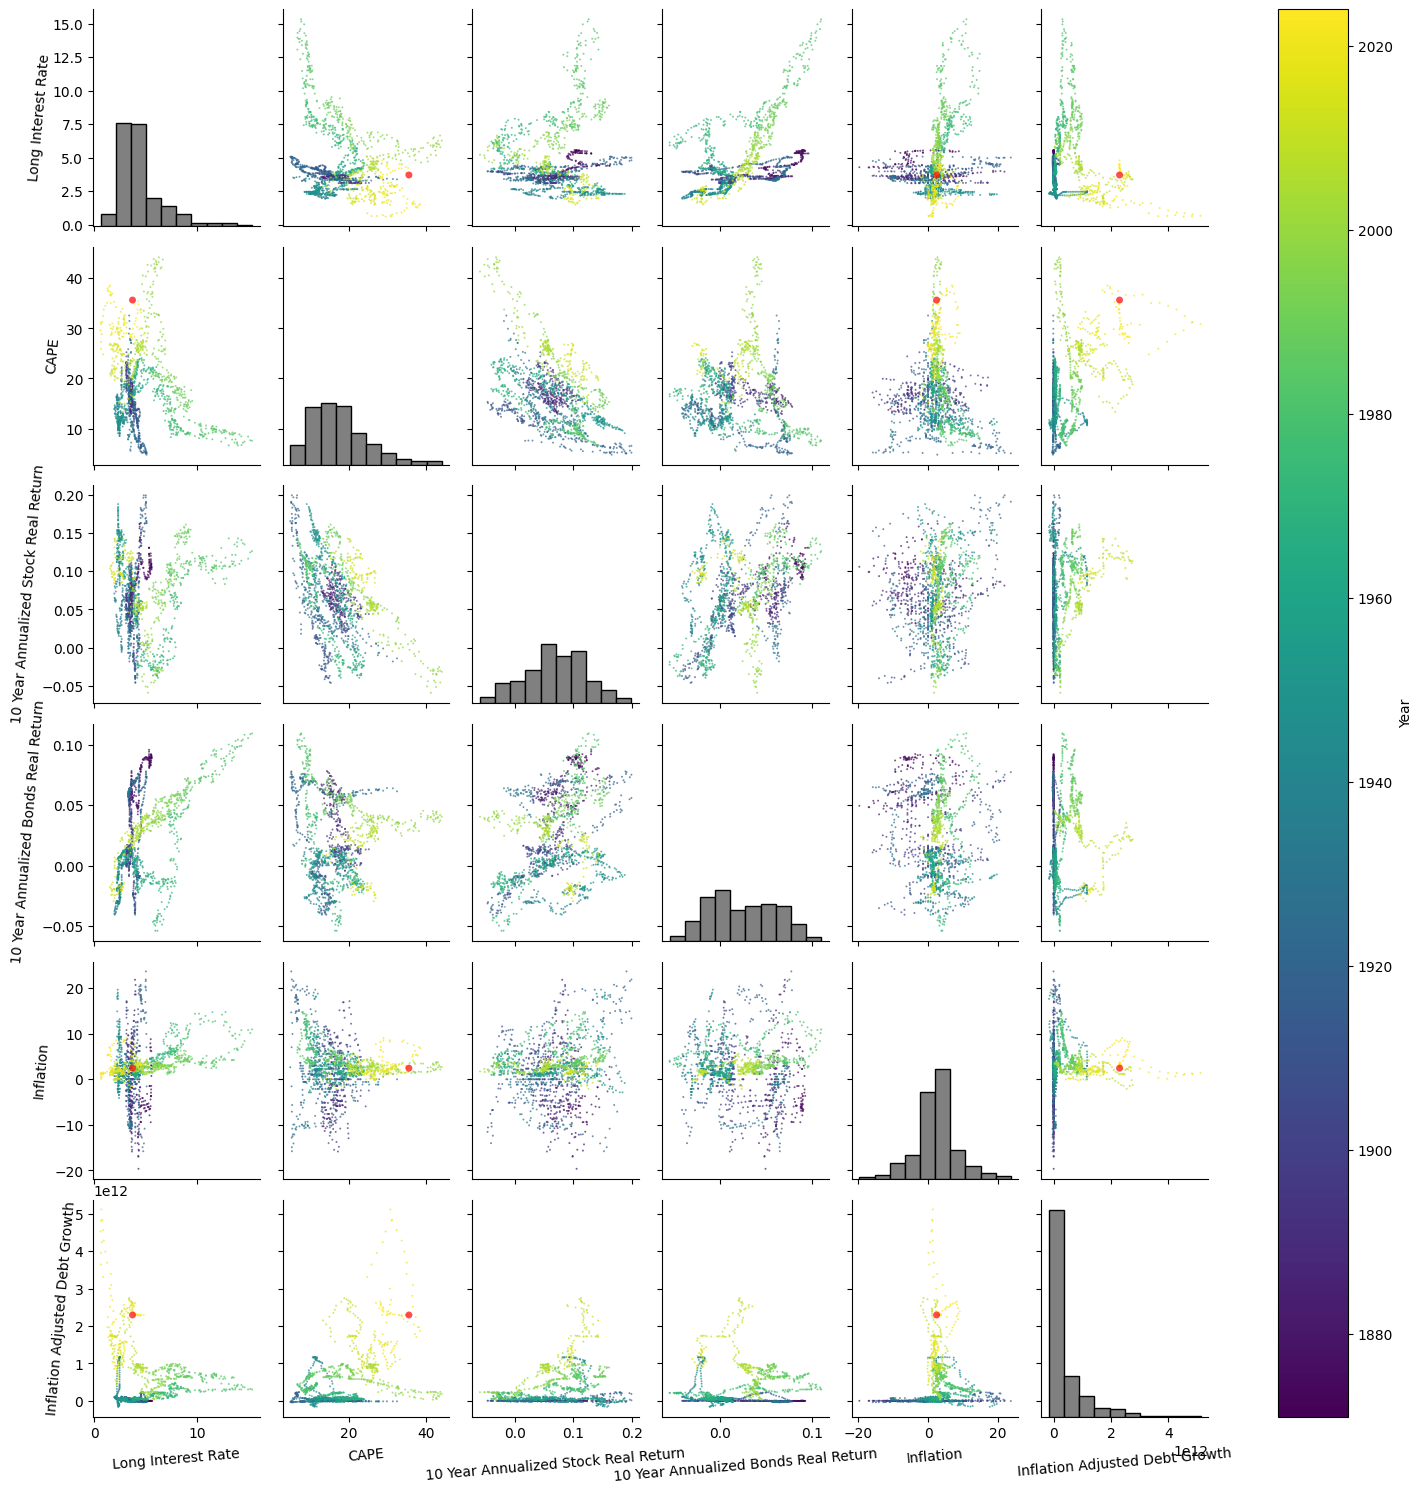

In [ ]:
# Prepare the data
pairplot_df = df[["Long Interest Rate",
  "CAPE",
  "10 Year Annualized Stock Real Return",
  "10 Year Annualized Bonds Real Return",
  "Inflation",
  "Inflation Adjusted Debt Growth"
]]
norm = Normalize(vmin=1871, vmax=2024)
cmap = plt.cm.viridis

# Create base colors
colors = cmap(norm(df['Date']))

# Identify the index of the max date
max_date_idx = df['Date'].idxmax()

# Replace color at that index with red
highlighted_colors = colors.copy()
sizes = np.full(len(df), 2)  # default size 2
sizes[max_date_idx] = 25     # make the max date point much larger
highlighted_colors[max_date_idx] = [1, 0, 0, 1]  # RGBA for red

# Plot using seaborn PairGrid
g = sns.PairGrid(pairplot_df)
g.map_offdiag(plt.scatter, color=highlighted_colors, alpha=0.7, s=sizes, edgecolors='none')
g.map_diag(plt.hist, color='gray', edgecolor='black')

# Rotate axis labels
for ax in g.axes[-1, :]:
    ax.set_xlabel(ax.get_xlabel(), rotation=5)
for ax in g.axes[:, 0]:
    ax.set_ylabel(ax.get_ylabel(), rotation=85)

# Add colorbar legend for year
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
g.fig.colorbar(sm, ax=g.axes, orientation='vertical', label='Year')

plt.show()


There appears to be a strong relationship between the Long-term Interest Rate and the other variables. However, the high interest rates only occurred in the 1980s, so these trends should be viewed with skepticism.

CAPE has an interesting relationship with the 10-year annualized stock returns, such that a high CAPE value corresponds to a low stock return value. Low CAPE values are less strongly correlated with high stock returns, but high CAPE values appear to put a cap on stock performance.

We are currently in a period of historically high and rising CAPE measurements (> 25). The other periods of history with similarly high CAPE measurements are 1925-1930 and 1995-2000.

### Future Analysis

One interesting study that could be done is to statistically model 1, 2, 5, and 10-year annualized stock returns as a function of the dependent variables with multiple regression. We could also classify each point based on whether the Excess Annaul Stock Returns are positive or negative and use logistic regression to classify the points. If the classifier is accurate, it could tell us whether we should invest in stocks or bonds at a given time.

The individual factors are not powerfully predictive of our objectives, so we should investigate interaction factors.